In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
data = pd.read_csv("./ZippedDatasets/Kick.csv")
data.head()

/home/vedantc6/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,9,11,12,14,15,16,18,20,25,29,30,32,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,4,Handmade glass trees that make a special Chris...,"{""id"":347,""name"":""Glass"",""slug"":""crafts/glass""...",205,US,1464927602,"{""id"":661261267,""name"":""Mark & Julie Glocke"",""...",USD,$,true,...,glass-christmas-trees-and-glass-cross,https://www.kickstarter.com/discover/categorie...,false,false,failed,1466474764,1,"{""web"":{""project"":""https://www.kickstarter.com...",205.0,domestic
1,171,Perfect pair of Socks for any Adventurer! Sock...,"{""id"":34,""name"":""Tabletop Games"",""slug"":""games...",6061,US,1540391660,"{""id"":497057119,""name"":""Andy ""Cosmo-Joe"" Watki...",USD,$,true,...,socks-of-speed-and-socks-of-elvenkind,https://www.kickstarter.com/discover/categorie...,true,false,successful,1542304740,1,"{""web"":{""project"":""https://www.kickstarter.com...",6061.0,international
2,9,This is a Series of 6 Books on Blessed Oscar A...,"{""id"":327,""name"":""Translations"",""slug"":""publis...",800,US,1434584826,"{""id"":267701790,""name"":""Convivium Press"",""slug...",USD,$,true,...,the-complete-homilies-of-blessed-oscar-romero-...,https://www.kickstarter.com/discover/categorie...,false,false,failed,1439741591,1,"{""web"":{""project"":""https://www.kickstarter.com...",800.0,domestic
3,24,Prodeus makes self employment simple and intui...,"{""id"":342,""name"":""Web"",""slug"":""technology/web""...",1484,US,1493997043,"{""id"":973039847,""name"":""James Harr"",""is_regist...",USD,$,true,...,prodeus-social-network-learning-community-micr...,https://www.kickstarter.com/discover/categorie...,false,false,failed,1498060876,1,"{""web"":{""project"":""https://www.kickstarter.com...",1484.0,domestic
4,62,"Welcome to Dungeon Corp LTD, a Dungeons and Dr...","{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",1066,ES,1544546012,"{""id"":496847178,""name"":""Eternalverse"",""slug"":""...",EUR,€,false,...,dungeon-corp-ltd-the-adventures-of-bob-and-tim,https://www.kickstarter.com/discover/categorie...,false,true,live,1547165608,1.15586358,"{""web"":{""project"":""https://www.kickstarter.com...",1087.66762878,domestic


In [3]:
min_value = int(0.3*len(data))
data = data.dropna(thresh=min_value, axis='columns')
data = data.dropna(axis='rows')
data = data.drop(axis='rows', index=data[data.created_at == "created_at"].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619620 entries, 0 to 623712
Data columns (total 33 columns):
backers_count               619620 non-null object
blurb                       619620 non-null object
category                    619620 non-null object
converted_pledged_amount    619620 non-null object
country                     619620 non-null object
created_at                  619620 non-null object
creator                     619620 non-null object
currency                    619620 non-null object
currency_symbol             619620 non-null object
currency_trailing_code      619620 non-null object
current_currency            619620 non-null object
deadline                    619620 non-null object
disable_communication       619620 non-null object
fx_rate                     619620 non-null object
goal                        619620 non-null object
id                          619620 non-null object
is_starrable                619620 non-null object
launched_at           

In [4]:
def find_loc(text, val):
    pos = text.find(val)
    if pos:
        if "id" in val:
            start = pos + len(val) + 2
            temp = text[start:]
            end = temp.find(",")
        elif val =="slug":
            start = pos + len(val) + 3
            temp = text[start:]
            end = min(temp.find("/"),temp.find("\""))
        else:
            start = pos + len(val) + 3
            temp = text[start:]
            end = temp.find("\"")
        return text[start:start+end]
    else:
        return ''

def classifier(row):
    if row in ['AG', 'AI', 'AN', 'AW', 'BB', 'BL', 'BM', 'BS', 'BZ', 'CA', 'CR', 'CU', 'DM', 'DO', 'GD', 'GL', 'GP', 'GT', 'HN', 'HT', 'JM', 'KN', 'KY', 'LC', 'MF', 'MQ', 'MS', 'MX', 'NI', 'PA', 'PM', 'PR', 'SV', 'TC', 'TT', 'US', 'VC', 'VG', 'VI', ]:
        return 'North America'
    elif row in ['AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'FK', 'GF', 'GY', 'PE', 'PY', 'SR', 'UY', 'VE']:
        return 'South America'
    elif row in ['AO', 'BF', 'BI', 'BJ', 'BW', 'CD', 'CF', 'CG', 'CI', 'CM', 'CV', 'DJ', 'DZ', 'EG', 'EH', 'ER', 'ET', 'GA', 'GH', 'GM', 'GN', 'GQ', 'GW', 'KE', 'KM', 'LR', 'LS', 'LY', 'MA', 'MG', 'ML', 'MR', 'MU', 'MW', 'MZ', 'NA', 'NE', 'NG', 'RE', 'RW', 'SC', 'SD', 'SH', 'SL', 'SN', 'SO', 'ST', 'SZ', 'TD', 'TG', 'TN', 'TZ', 'UG', 'YT', 'ZA', 'ZM', 'ZW']:
        return 'Africa'
    elif row in ['AD', 'AL', 'AT', 'AX', 'BA', 'BE', 'BG', 'BY', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'EU', 'FI', 'FO', 'FR', 'FX', 'GB', 'GG', 'GI', 'GR', 'HR', 'HU', 'IE', 'IM', 'IS', 'IT', 'JE', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SJ', 'SK', 'SM', 'TR', 'UA', 'VA']:
        return 'Europe'
    elif row in ['AE', 'AF', 'AM', 'AP', 'AZ', 'BD', 'BH', 'BN', 'BT', 'CC', 'CN', 'CX', 'CY', 'GE', 'HK', 'ID', 'IL', 'IN', 'IO', 'IQ', 'IR', 'JO', 'JP', 'KG', 'KH', 'KP', 'KR', 'KW', 'KZ', 'LA', 'LB', 'LK', 'MM', 'MN', 'MO', 'MV', 'MY', 'NP', 'OM', 'PH', 'PK', 'PS', 'QA', 'SA', 'SG', 'SY', 'TH', 'TJ', 'TL', 'TM', 'TW', 'UZ', 'VN', 'YE']:
        return 'Asia'
    else:
        return "Oceania"
    
def convert_date(unixtime):
    temp = int(unixtime)
    return datetime.utcfromtimestamp(temp).strftime('%Y-%m-%d')
    
def url_fetch(x):
    temp = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)
    return " ".join(str(t) for t in temp)

def create_new_cols(data):
    data['cat_id'] = data["category"].apply(lambda x: find_loc(x, "id"))
    data['cat_name'] = data["category"].apply(lambda x: find_loc(x, "name"))
    data['cat_parent'] = data["category"].apply(lambda x: find_loc(x, "slug"))
    data['cat_parent_id'] = data["category"].apply(lambda x: find_loc(x, "parent_id"))
    data['cat_link'] = data["category"].apply(lambda x: url_fetch(x))

    data['creator_id'] = data["creator"].apply(lambda x: find_loc(x, "id"))
    data['creator_name'] = data["creator"].apply(lambda x: find_loc(x, "name"))
    data['creater_registered'] = data["creator"].apply(lambda x: "True" if 'true' in x else "False")
        
    data['loc_id'] = data["location"].apply(lambda x: find_loc(x, "id"))
    data['loc_name'] = data["location"].apply(lambda x: find_loc(x, "name"))
    data['loc_state'] = data["location"].apply(lambda x: find_loc(x,'state'))
    data['loc_country'] = data["location"].apply(lambda x: find_loc(x, 'country'))
    data['loc_type'] = data["location"].apply(lambda x: find_loc(x, 'type'))
    data['loc_url'] = data["location"].apply(lambda x: url_fetch(x))
    data['continent'] = data["loc_country"].apply(lambda x: classifier(x))
#     Taking a lot of time
    data['photo_url'] = data["photo"].apply(lambda x: url_fetch(x))
    
    data['profile_id'] = data["profile"].apply(lambda x: find_loc(x, "id"))
    data['project_id'] = data["profile"].apply(lambda x: find_loc(x, "id"))
    
    data['project_url'] = data["urls"].apply(lambda x: url_fetch(x))
    data['created_at'] = pd.to_datetime(data['created_at'].apply(lambda x: convert_date(x)))
    data['deadline'] = pd.to_datetime(data['deadline'].apply(lambda x: convert_date(x)))
    data['launched_at'] = pd.to_datetime(data['launched_at'].apply(lambda x: convert_date(x)))
    data['state_changed_at'] = data['state_changed_at'].apply(lambda x: convert_date(x))
    
    data['spotlight'] = data['spotlight'].apply(lambda x: True if x in ['true','True'] else False)
    
    data['campaign_length'] = (data['deadline'] - data['launched_at']).dt.days
    
    data['year'] = data['launched_at'].dt.year
    data['month'] = data['launched_at'].dt.month
    data['day'] = data['launched_at'].dt.day
    
    data = data.drop(['country', 'category', 'creator', 'location', 'photo', 'profile', 'urls', 'currency_trailing_code', 'disable_communication'], axis=1)
    return data

In [5]:
data2 = create_new_cols(data)
data2.head()

,backers_count,blurb,converted_pledged_amount,created_at,currency,currency_symbol,current_currency,deadline,fx_rate,goal,...,loc_url,continent,photo_url,profile_id,project_id,project_url,campaign_length,year,month,day
0,4,Handmade glass trees that make a special Chris...,205,2016-06-03,USD,$,USD,2016-06-21,1,1000,...,https://www.kickstarter.com/discover/places/tu...,North America,https://ksr-ugc.imgix.net/assets/012/621/061/7...,2543897,2543897,https://www.kickstarter.com/projects/coldglass...,17,2016,6,4
1,171,Perfect pair of Socks for any Adventurer! Sock...,6061,2018-10-24,USD,$,USD,2018-11-15,1,2000,...,https://www.kickstarter.com/discover/places/me...,North America,https://ksr-ugc.imgix.net/assets/023/068/417/2...,3498932,3498932,https://www.kickstarter.com/projects/497057119...,16,2018,10,30
2,9,This is a Series of 6 Books on Blessed Oscar A...,800,2015-06-17,USD,$,USD,2015-08-16,1,4400,...,https://www.kickstarter.com/discover/places/mi...,North America,https://ksr-ugc.imgix.net/assets/012/171/280/2...,1965582,1965582,https://www.kickstarter.com/projects/convivium...,40,2015,7,7
3,24,Prodeus makes self employment simple and intui...,1484,2017-05-05,USD,$,USD,2017-06-21,1,50000,...,https://www.kickstarter.com/discover/places/br...,North America,https://ksr-ugc.imgix.net/assets/016/544/145/e...,2988723,2988723,https://www.kickstarter.com/projects/973039847...,30,2017,5,22
4,62,"Welcome to Dungeon Corp LTD, a Dungeons and Dr...",1066,2018-12-11,EUR,€,USD,2019-02-15,1.13368788,700,...,https://www.kickstarter.com/discover/places/vi...,Europe,https://ksr-ugc.imgix.net/assets/023/542/956/0...,3533340,3533340,https://www.kickstarter.com/projects/eternalve...,35,2019,1,11


In [6]:
data2 = data2[data2.project_id.duplicated() == False]
data2.head()

,backers_count,blurb,converted_pledged_amount,created_at,currency,currency_symbol,current_currency,deadline,fx_rate,goal,...,loc_url,continent,photo_url,profile_id,project_id,project_url,campaign_length,year,month,day
0,4,Handmade glass trees that make a special Chris...,205,2016-06-03,USD,$,USD,2016-06-21,1,1000,...,https://www.kickstarter.com/discover/places/tu...,North America,https://ksr-ugc.imgix.net/assets/012/621/061/7...,2543897,2543897,https://www.kickstarter.com/projects/coldglass...,17,2016,6,4
1,171,Perfect pair of Socks for any Adventurer! Sock...,6061,2018-10-24,USD,$,USD,2018-11-15,1,2000,...,https://www.kickstarter.com/discover/places/me...,North America,https://ksr-ugc.imgix.net/assets/023/068/417/2...,3498932,3498932,https://www.kickstarter.com/projects/497057119...,16,2018,10,30
2,9,This is a Series of 6 Books on Blessed Oscar A...,800,2015-06-17,USD,$,USD,2015-08-16,1,4400,...,https://www.kickstarter.com/discover/places/mi...,North America,https://ksr-ugc.imgix.net/assets/012/171/280/2...,1965582,1965582,https://www.kickstarter.com/projects/convivium...,40,2015,7,7
3,24,Prodeus makes self employment simple and intui...,1484,2017-05-05,USD,$,USD,2017-06-21,1,50000,...,https://www.kickstarter.com/discover/places/br...,North America,https://ksr-ugc.imgix.net/assets/016/544/145/e...,2988723,2988723,https://www.kickstarter.com/projects/973039847...,30,2017,5,22
4,62,"Welcome to Dungeon Corp LTD, a Dungeons and Dr...",1066,2018-12-11,EUR,€,USD,2019-02-15,1.13368788,700,...,https://www.kickstarter.com/discover/places/vi...,Europe,https://ksr-ugc.imgix.net/assets/023/542/956/0...,3533340,3533340,https://www.kickstarter.com/projects/eternalve...,35,2019,1,11


In [7]:
# data2.to_csv("KickStarter2018_v2.csv", index=False)
data2.iloc[0]

backers_count                                                               4
blurb                       Handmade glass trees that make a special Chris...
converted_pledged_amount                                                  205
created_at                                                2016-06-03 00:00:00
currency                                                                  USD
currency_symbol                                                             $
current_currency                                                          USD
deadline                                                  2016-06-21 00:00:00
fx_rate                                                                     1
goal                                                                     1000
id                                                                 1145008426
is_starrable                                                            false
launched_at                                               2016-0

Percentages by state (live/successful/failure etc.)
successful    53.84
failed        39.71
canceled       3.98
live           2.19
suspended      0.28
Name: state, dtype: float64


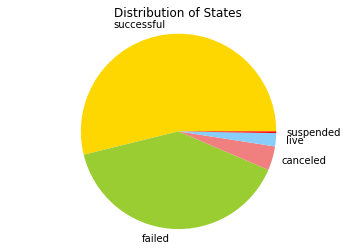

In [8]:
# EDA
# By state
percentage_success = round(data2["state"].value_counts()/len(data2["state"])*100,2)

print("Percentages by state (live/successful/failure etc.)")
print(percentage_success)

labels = percentage_success.index
values = percentage_success.values

colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']

plt.pie(values, labels=labels, colors=colors)
plt.axis('equal')
plt.title('Distribution of States')
plt.savefig("images/breakdown_of_status.jpg")
plt.show()


For the current data, we see that successful projects are 56%. We also see that successful and failed projects have good proportions, so we can do some predictive analysis on them later on

Percentages by category
music           14.35
film & video    14.15
technology      11.16
art              9.90
publishing       8.84
food             7.73
games            6.97
fashion          5.76
design           4.25
comics           3.86
photography      3.39
theater          3.27
crafts           2.77
journalism       2.14
dance            1.44
Name: cat_parent, dtype: float64


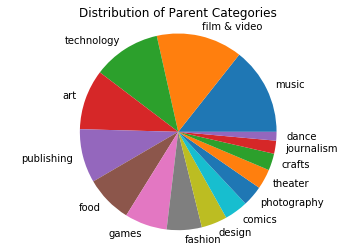

In [9]:
# By category
category_perc = round(data2["cat_parent"].value_counts()/len(data2["cat_parent"])*100,2)

print("Percentages by category")
print(category_perc)

labels = category_perc.index
values = category_perc.values


plt.pie(values, labels=labels)
plt.axis('equal')
plt.title('Distribution of Parent Categories')
plt.savefig("images/distribution_category.jpg")
plt.show()

Percentages by continent
North America    78.14
Europe           16.97
Oceania           2.48
Asia              1.79
Africa            0.34
South America     0.29
Name: continent, dtype: float64


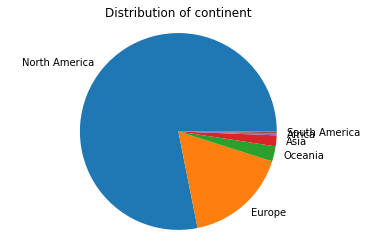

In [10]:
# By continent
continent_perc = round(data2["continent"].value_counts()/len(data2["continent"])*100,2)

print("Percentages by continent")
print(continent_perc)

labels = continent_perc.index
values = continent_perc.values


plt.pie(values, labels=labels)
plt.axis('equal')
plt.title('Distribution of continent')
plt.savefig("images/continents.jpg")
plt.show()

In [11]:
data2.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'created_at',
       'currency', 'currency_symbol', 'current_currency', 'deadline',
       'fx_rate', 'goal', 'id', 'is_starrable', 'launched_at', 'name',
       'pledged', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type',
       'cat_id', 'cat_name', 'cat_parent', 'cat_parent_id', 'cat_link',
       'creator_id', 'creator_name', 'creater_registered', 'loc_id',
       'loc_name', 'loc_state', 'loc_country', 'loc_type', 'loc_url',
       'continent', 'photo_url', 'profile_id', 'project_id', 'project_url',
       'campaign_length', 'year', 'month', 'day'],
      dtype='object')

In [12]:
stopwords = ["video,dance,journalism,crafts,theater,photography,comics,design,fashion,games,food,publishing,art,technology,film,music,category,kickstart,kickstarter,pledge,goal,now,should,don't,just,will,can,very,too,than,so,same,own,only,not,nor,no,such,some,other,most,more,few,each,both,any,all,how,why,where,when,there,here,once,then,further,again,under,over,off,on,out,in,down,up,from,to,below,above,after,before,during,through,into,between,against,about,with,for,by,at,of,while,until,as,because,or,if,but,and,the,an,a,doing,did,does,do,having,had,has,have,being,been,be,were,was,are,is,am,those,these,that,this,whom,who,which,what,themselves,theirs,their,them,they,itself,its,it,herself,hers,her,she,himself,his,him,he,yourselves,yourself,yours,your,you,ourselves,ours,our,we,myself,my,me,i"]

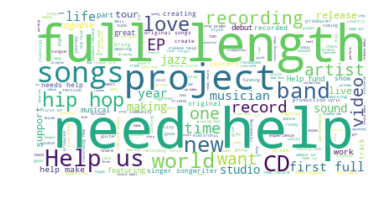

In [125]:
# MUSIC
temp = data2[data2.cat_parent == category_perc.index[0]].blurb
temp.iloc[0]
text = " ".join(temp.iloc[i] for i in range(len(temp)))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

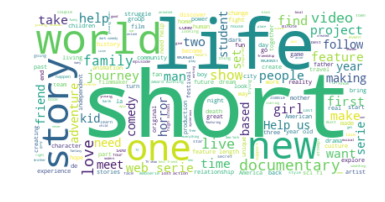

In [14]:
temp = data2[data2.cat_parent == category_perc.index[1]].blurb
temp.iloc[0]
text = " ".join(temp.iloc[i] for i in range(len(temp)))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

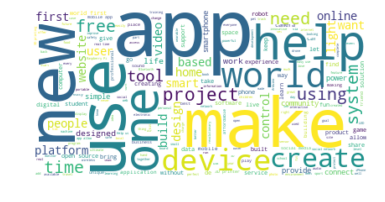

In [15]:
temp = data2[data2.cat_parent == category_perc.index[2]].blurb
temp.iloc[0]
text = " ".join(temp.iloc[i] for i in range(len(temp)))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

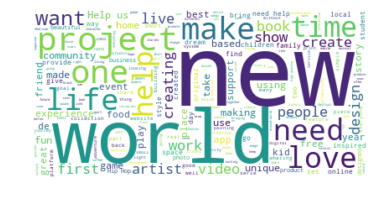

In [184]:
temp = data2[data2.state == 'failed'].blurb
# temp.iloc[0]
text = " ".join(temp.iloc[i] for i in range(len(temp)))
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [202]:
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords) 
  
temp = data2[data2.state == 'failed'].blurb
# temp.iloc[0]
text = " ".join(temp.iloc[i] for i in range(len(temp)))

word_tokens = word_tokenize(text) 
  
filtered_sentence = [w.lower() for w in word_tokens if not w in stop_words if w.isalpha() if len(w) > 5] 

d = {}
for w in filtered_sentence:
    if str(w) not in d:
        d[str(w)] = 1
    d[w] += 1

deletion = []
for key, val in d.items():
    if val < 500:
        deletion.append(key)
for de in deletion:
    del d[de]
    
word_count = []
for key, val in d.items():
    each_data = {}
    each_data['tag'] = key
    each_data['count'] = str(val)
    word_count.append(each_data)
    
print(word_count)

[{'tag': 'handmade', 'count': '610'}, {'tag': 'special', 'count': '522'}, {'tag': 'series', 'count': '2208'}, {'tag': 'project', 'count': '3714'}, {'tag': 'simple', 'count': '936'}, {'tag': 'business', 'count': '1518'}, {'tag': 'social', 'count': '1452'}, {'tag': 'platform', 'count': '1168'}, {'tag': 'history', 'count': '689'}, {'tag': 'community', 'count': '2065'}, {'tag': 'network', 'count': '566'}, {'tag': 'create', 'count': '4021'}, {'tag': 'market', 'count': '506'}, {'tag': 'adventure', 'count': '610'}, {'tag': 'looking', 'count': '1603'}, {'tag': 'creating', 'count': '2435'}, {'tag': 'photos', 'count': '616'}, {'tag': 'beautiful', 'count': '1163'}, {'tag': 'perfect', 'count': '535'}, {'tag': 'website', 'count': '1207'}, {'tag': 'change', 'count': '826'}, {'tag': 'making', 'count': '1761'}, {'tag': 'personal', 'count': '610'}, {'tag': 'featuring', 'count': '872'}, {'tag': 'favorite', 'count': '538'}, {'tag': 'classic', 'count': '566'}, {'tag': 'unique', 'count': '2036'}, {'tag': '

In [201]:
len(d)

182

In [17]:
usa_data = data2[data2.loc_country == "US"]
usa_data.head()

,backers_count,blurb,converted_pledged_amount,created_at,currency,currency_symbol,current_currency,deadline,fx_rate,goal,...,loc_url,continent,photo_url,profile_id,project_id,project_url,campaign_length,year,month,day
0,4,Handmade glass trees that make a special Chris...,205,2016-06-03,USD,$,USD,2016-06-21,1,1000,...,https://www.kickstarter.com/discover/places/tu...,North America,https://ksr-ugc.imgix.net/assets/012/621/061/7...,2543897,2543897,https://www.kickstarter.com/projects/coldglass...,17,2016,6,4
1,171,Perfect pair of Socks for any Adventurer! Sock...,6061,2018-10-24,USD,$,USD,2018-11-15,1,2000,...,https://www.kickstarter.com/discover/places/me...,North America,https://ksr-ugc.imgix.net/assets/023/068/417/2...,3498932,3498932,https://www.kickstarter.com/projects/497057119...,16,2018,10,30
2,9,This is a Series of 6 Books on Blessed Oscar A...,800,2015-06-17,USD,$,USD,2015-08-16,1,4400,...,https://www.kickstarter.com/discover/places/mi...,North America,https://ksr-ugc.imgix.net/assets/012/171/280/2...,1965582,1965582,https://www.kickstarter.com/projects/convivium...,40,2015,7,7
3,24,Prodeus makes self employment simple and intui...,1484,2017-05-05,USD,$,USD,2017-06-21,1,50000,...,https://www.kickstarter.com/discover/places/br...,North America,https://ksr-ugc.imgix.net/assets/016/544/145/e...,2988723,2988723,https://www.kickstarter.com/projects/973039847...,30,2017,5,22
6,17,Sixxeight is a shirt brand hosting a live scre...,1110,2017-05-15,USD,$,USD,2017-07-09,1,1100,...,https://www.kickstarter.com/discover/places/ma...,North America,https://ksr-ugc.imgix.net/assets/016/684/832/a...,3001672,3001672,https://www.kickstarter.com/projects/198272297...,30,2017,6,9


Percentages by state
CA    19.11
NY    12.24
TX     5.82
FL     4.80
IL     3.98
WA     3.38
PA     3.18
MA     2.92
GA     2.67
OR     2.61
Name: loc_state, dtype: float64


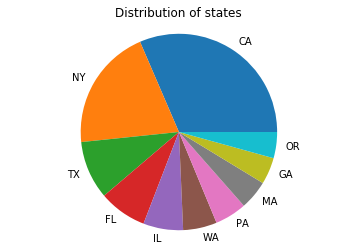

In [18]:
# By continent
usa_data = data2[data2.loc_country == "US"]
state_perc = round(usa_data["loc_state"].value_counts()/len(usa_data["loc_state"])*100,2)
state_perc = state_perc.head(10)
print("Percentages by state")
print(state_perc)

labels = state_perc.index
values = state_perc.values

plt.pie(values, labels=labels)
plt.axis('equal')
plt.title('Distribution of states')
plt.savefig("images/us_states.jpg")
plt.show()

In [19]:
usa_data[usa_data.loc_state == "CA"].state.value_counts()

successful    18662
failed        10667
canceled       1174
live            511
suspended        74
Name: state, dtype: int64

In [20]:
def get_piechart_data():
    category_perc = round(data2["cat_parent"].value_counts()/len(data2["cat_parent"])*100,2)
    pie_chart_data = []
    for index, item in zip(category_perc.index, category_perc.values):
        each_data = {}
        each_data['category'] = index
        each_data['percentage'] = round(item, 2)
        
        pie_chart_data.append(each_data)
        
    print(pie_chart_data)
                
get_piechart_data()

[{'category': 'music', 'percentage': 14.35}, {'category': 'film & video', 'percentage': 14.15}, {'category': 'technology', 'percentage': 11.16}, {'category': 'art', 'percentage': 9.9}, {'category': 'publishing', 'percentage': 8.84}, {'category': 'food', 'percentage': 7.73}, {'category': 'games', 'percentage': 6.97}, {'category': 'fashion', 'percentage': 5.76}, {'category': 'design', 'percentage': 4.25}, {'category': 'comics', 'percentage': 3.86}, {'category': 'photography', 'percentage': 3.39}, {'category': 'theater', 'percentage': 3.27}, {'category': 'crafts', 'percentage': 2.77}, {'category': 'journalism', 'percentage': 2.14}, {'category': 'dance', 'percentage': 1.44}]


In [21]:
def get_barchart_data():
    bar_chart_data = []
    percentage_success = round(data2["state"].value_counts()/len(data2["state"])*100,2)
    for index, item in zip(percentage_success.index, percentage_success.values):
        each_data = {}
        each_data['group'] = "All"
        each_data['category'] = index
        each_data['percentage'] = round(item, 2)
        
        bar_chart_data.append(each_data)

    status_labels = list(data2.state.unique())
    
    for value in data2.cat_parent.unique():
        filtered = data2[data2.cat_parent == value]
        percentage_data = round(filtered["state"].value_counts()/len(filtered["state"])*100, 2)
        for index, item in zip(percentage_data.index, percentage_data.values):
            each_data = {}
            each_data['group'] = str(value)
            each_data['category'] = index
            each_data['percentage'] = round(item, 2)
            
            bar_chart_data.append(each_data)
        
    
get_barchart_data()

In [22]:
def get_spotlight_data():
    spotlight = data2[data2.spotlight == True]
    spotlight['hasName'] = spotlight['name'].apply(lambda x: str(x).isalpha())
    spotlight = spotlight[spotlight.hasName == True]
    spotlight['converted_pledged_amount'] = spotlight['converted_pledged_amount'].astype('float32')
    spotlight['goal'] = spotlight['goal'].astype('float32')
    spotlight['pledge_percentage'] = spotlight['converted_pledged_amount'].divide(spotlight['goal'], fill_value=0)*100
    spotlight = spotlight[spotlight.pledge_percentage <= 1000]
    categories = spotlight.cat_parent.unique()
    spotlight_data = []
    for cat in categories:
        cat_data = spotlight[spotlight.cat_parent == cat]
        cat_data = cat_data.sort_values(by=['pledge_percentage'], ascending=False)
        cat_data = cat_data.head(5)
        
        for i in range(len(cat_data)):
            each_data = {}
            each_data['projID'] = cat_data.iloc[i].project_id
            each_data['name'] = cat_data.iloc[i]["name"]
            try:
                each_data['projURL'] = cat_data.iloc[i].project_url.split(" ")[0]
            except:
                each_data['projURL'] = cat_data.iloc[i].project_url
            each_data['cat_parent'] = cat
            each_data['category'] = cat_data.iloc[i].cat_name
            each_data['blurb'] = cat_data.iloc[i].blurb
            each_data['priority'] = cat_data.iloc[i].pledge_percentage
            
            spotlight_data.append(each_data)
    
    print(spotlight_data)
    
get_spotlight_data()

/home/vedantc6/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[{'projID': '666063', 'name': 'OMORI', 'projURL': 'https://www.kickstarter.com/projects/omocat/omori?ref=discovery_category_newest', 'cat_parent': 'games', 'category': 'Video Games', 'blurb': 'A surreal, exploration, horror RPG. Travel between new (old) worlds and uncover new (old) mysteries with your new (old) friends! ♥', 'priority': 924.0909}, {'projID': '2455553', 'name': 'GLITCHED', 'projURL': 'https://www.kickstarter.com/projects/enhousestudios/glitched?ref=discovery_category_newest', 'cat_parent': 'games', 'category': 'Video Games', 'blurb': 'A fourth wall breaking RPG where the hero slowly realizes that you, the player, exist.', 'priority': 915.27997}, {'projID': '3272527', 'name': 'Inoka', 'projURL': 'https://www.kickstarter.com/projects/xyzgamelabs/inoka?ref=discovery_category_newest', 'cat_parent': 'games', 'category': 'Tabletop Games', 'blurb': "Long ago, the forest's most enlightened creatures, the Inoka, clashed in a game of strategy & wits to become Nature's Emissary.", 

In [23]:
data2.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'created_at',
       'currency', 'currency_symbol', 'current_currency', 'deadline',
       'fx_rate', 'goal', 'id', 'is_starrable', 'launched_at', 'name',
       'pledged', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type',
       'cat_id', 'cat_name', 'cat_parent', 'cat_parent_id', 'cat_link',
       'creator_id', 'creator_name', 'creater_registered', 'loc_id',
       'loc_name', 'loc_state', 'loc_country', 'loc_type', 'loc_url',
       'continent', 'photo_url', 'profile_id', 'project_id', 'project_url',
       'campaign_length', 'year', 'month', 'day'],
      dtype='object')

In [57]:
def get_line_chart_data():
    by_year = data2.year.value_counts()
    line_chart_data = []
    for index, item in zip(by_year.index, by_year.values):
        year_data = data2[data2.year == index]
        by_month = year_data.month.value_counts()
        for m_index, m_item in zip(by_month.index, by_month.values):
#             print(year_data.year.unique(), m_index, m_item)
            each_data = {}
            each_data['year'] = index
            each_data['month'] = m_index
            each_data['value'] = m_item
        
            line_chart_data.append(each_data)
        
    print(line_chart_data)
    
get_line_chart_data()

[{'year': 2015, 'month': 3, 'value': 4467}, {'year': 2015, 'month': 2, 'value': 4201}, {'year': 2015, 'month': 4, 'value': 4074}, {'year': 2015, 'month': 5, 'value': 3747}, {'year': 2015, 'month': 6, 'value': 3648}, {'year': 2015, 'month': 1, 'value': 3613}, {'year': 2015, 'month': 7, 'value': 3120}, {'year': 2015, 'month': 11, 'value': 2971}, {'year': 2015, 'month': 9, 'value': 2926}, {'year': 2015, 'month': 10, 'value': 2890}, {'year': 2015, 'month': 8, 'value': 2860}, {'year': 2015, 'month': 12, 'value': 1922}, {'year': 2014, 'month': 7, 'value': 5783}, {'year': 2014, 'month': 8, 'value': 4151}, {'year': 2014, 'month': 10, 'value': 3733}, {'year': 2014, 'month': 9, 'value': 3572}, {'year': 2014, 'month': 11, 'value': 3264}, {'year': 2014, 'month': 6, 'value': 2793}, {'year': 2014, 'month': 5, 'value': 2482}, {'year': 2014, 'month': 12, 'value': 2280}, {'year': 2014, 'month': 4, 'value': 1938}, {'year': 2014, 'month': 3, 'value': 1797}, {'year': 2014, 'month': 2, 'value': 1595}, {'ye

In [25]:
import csv
    
def world_data():
    with open('countries.csv', mode='r') as infile:
        reader = csv.reader(infile)
        next(reader)
        my_dict = {}
        for row in reader:
    #         print(row)
            if row[1] not in my_dict:
                my_dict[row[1]] = [row[0], row[2]]
              
    countries = data2.loc_country.value_counts()
    country_data = []
    for index, item in zip(countries.index, countries.values):
        each_data = {}
        if index in my_dict:
            each_data['id'] = my_dict[index][1]
            each_data['country'] = my_dict[index][0]
#         else:
#             each_data['id'] = 'Not available'
#             each_data['country'] = 'NA'
        each_data['projects'] = item
        
        country_data.append(each_data)
        
    print(country_data)
        
world_data()

[{'id': 'USA', 'country': 'United States of America', 'projects': 162706}, {'id': 'GBR', 'country': 'United Kingdom of Great Britain and Northern Ireland', 'projects': 20580}, {'id': 'CAN', 'country': 'Canada', 'projects': 9091}, {'id': 'AUS', 'country': 'Australia', 'projects': 4535}, {'id': 'DEU', 'country': 'Germany', 'projects': 2995}, {'id': 'FRA', 'country': 'France', 'projects': 2387}, {'id': 'ITA', 'country': 'Italy', 'projects': 2229}, {'id': 'MEX', 'country': 'Mexico', 'projects': 2143}, {'id': 'ESP', 'country': 'Spain', 'projects': 1786}, {'id': 'NLD', 'country': 'Netherlands', 'projects': 1722}, {'id': 'SWE', 'country': 'Sweden', 'projects': 1259}, {'id': 'NZL', 'country': 'New Zealand', 'projects': 909}, {'id': 'DNK', 'country': 'Denmark', 'projects': 834}, {'id': 'HKG', 'country': 'Hong Kong', 'projects': 809}, {'id': 'JPN', 'country': 'Japan', 'projects': 673}, {'id': 'IRL', 'country': 'Ireland', 'projects': 588}, {'id': 'CHE', 'country': 'Switzerland', 'projects': 581},

In [214]:
def continent_country_map():
    with open('countries.csv', mode='r') as infile:
        reader = csv.reader(infile)
        next(reader)
        my_dict = {}
        for row in reader:
    #         print(row)
            if row[1] not in my_dict:
                my_dict[row[1]] = [row[0], row[2]]
                
    continents = data2.continent.unique()
    final_data = []
    for cont in continents:           
        filtered = data2[data2.continent == cont]
        countries = filtered.loc_country.unique()
        for coun in countries:
            each_data = {}
            if cont not in each_data:
                each_data["continent"] = cont
            if coun in my_dict:
                each_data["country_id"] = coun
                each_data['country'] = my_dict[coun][0] 
                each_data["value"] = int(len(filtered[filtered.loc_country == coun]))
                
            final_data.append(each_data)        
    print(final_data)
        
continent_country_map()

[{'continent': 'North America', 'country_id': 'US', 'country': 'United States of America', 'value': 162706}, {'continent': 'North America', 'country_id': 'CA', 'country': 'Canada', 'value': 9091}, {'continent': 'North America', 'country_id': 'PR', 'country': 'Puerto Rico', 'value': 155}, {'continent': 'North America', 'country_id': 'MX', 'country': 'Mexico', 'value': 2143}, {'continent': 'North America', 'country_id': 'BS', 'country': 'Bahamas', 'value': 8}, {'continent': 'North America', 'country_id': 'HT', 'country': 'Haiti', 'value': 51}, {'continent': 'North America', 'country_id': 'CU', 'country': 'Cuba', 'value': 48}, {'continent': 'North America', 'country_id': 'HN', 'country': 'Honduras', 'value': 20}, {'continent': 'North America', 'country_id': 'CR', 'country': 'Costa Rica', 'value': 62}, {'continent': 'North America', 'country_id': 'BZ', 'country': 'Belize', 'value': 23}, {'continent': 'North America', 'country_id': 'GT', 'country': 'Guatemala', 'value': 54}, {'continent': '

In [26]:
def usa_data():
    with open('us_state.csv', mode='r') as infile:
        reader = csv.reader(infile)
        next(reader)
        my_dict = {}
        for row in reader:
    #         print(row)
            if row[1] not in my_dict:
                my_dict[row[1]] = row[0]
                
    usa_data = data2[data2.loc_country == "US"]
    states = usa_data.loc_state.value_counts()
    usa = []
    unattended = []
    for index, item in zip(states.index, states.values):
        each_data = {}
        if index in my_dict:
            each_data['code'] = index
            each_data['state'] = my_dict[index]
            each_data['projects'] = int(item)
            usa.append(each_data)
        elif index:
            temp = index.split("-")[-1]
            each_data['code'] = temp.upper()
            each_data['state'] = my_dict[temp.upper()]
            each_data['projects'] = int(item)
            unattended.append(each_data)
        
    for val1 in unattended:
        for val2 in usa:
            if val1['state'] in val2['state']:
                val2['projects'] += val1['projects']
                
    for val in usa:
        temp = usa_data[usa_data['loc_state'] == val['code']]
        positive = temp[temp['state'] == 'successful'].state.value_counts()
        negative = temp[temp['state'] == 'failed'].state.value_counts()
        category = temp.cat_parent.value_counts()
        val['successful'] = int(positive.values)
        val['fail'] = int(negative.values)
        val['category'] = category.index[0]
    
    print(usa)
            
usa_data()

[{'code': 'CA', 'state': 'California', 'projects': 31088, 'successful': 18662, 'fail': 10667, 'category': 'film & video'}, {'code': 'NY', 'state': 'New York', 'projects': 20019, 'successful': 13437, 'fail': 5614, 'category': 'film & video'}, {'code': 'TX', 'state': 'Texas', 'projects': 9466, 'successful': 4688, 'fail': 4170, 'category': 'music'}, {'code': 'FL', 'state': 'Florida', 'projects': 7812, 'successful': 2948, 'fail': 4287, 'category': 'technology'}, {'code': 'IL', 'state': 'Illinois', 'projects': 6482, 'successful': 3894, 'fail': 2258, 'category': 'music'}, {'code': 'WA', 'state': 'Washington', 'projects': 5495, 'successful': 3490, 'fail': 1720, 'category': 'music'}, {'code': 'PA', 'state': 'Pennsylvania', 'projects': 5275, 'successful': 2997, 'fail': 1923, 'category': 'music'}, {'code': 'MA', 'state': 'Massachusetts', 'projects': 4758, 'successful': 3207, 'fail': 1341, 'category': 'music'}, {'code': 'GA', 'state': 'Georgia', 'projects': 4364, 'successful': 1871, 'fail': 2163,

In [27]:
data2[data2.loc_country == "AQ"]

,backers_count,blurb,converted_pledged_amount,created_at,currency,currency_symbol,current_currency,deadline,fx_rate,goal,...,loc_url,continent,photo_url,profile_id,project_id,project_url,campaign_length,year,month,day
7141,4,I will go to the edge of the flat Earth and ju...,685,2019-01-23,GBP,£,USD,2019-03-27,1.29033257,50000,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/023/971/311/2...,3649970,3649970,https://www.kickstarter.com/projects/turtlehou...,60,2019,1,26
10932,228,Join us in funding the edit of our feature fil...,27154,2014-08-21,NZD,$,USD,2014-11-23,0.68502957,27500,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/011/844/544/e...,1307390,1307390,https://www.kickstarter.com/projects/thinicefi...,30,2014,10,24
24135,30,A photographic project with the National Scien...,3200,2017-08-02,USD,$,USD,2017-10-14,1,1500,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/017/841/569/e...,3095128,3095128,https://www.kickstarter.com/projects/132232080...,30,2017,9,14
33223,14,Wish Fluid Physical CD Release,328,2018-09-29,USD,$,USD,2018-11-03,1,300,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/022/780/943/3...,3480769,3480769,https://www.kickstarter.com/projects/931462285...,30,2018,10,4
38963,88,Painting all the oceans on the planet and sail...,15465,2018-09-17,USD,$,USD,2018-11-13,1,10000,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/022/786/390/1...,3472489,3472489,https://www.kickstarter.com/projects/113237740...,21,2018,10,23
45939,41,Help me make a dream trip to Antarctica into a...,4338,2014-11-30,USD,$,USD,2015-01-21,1,2000,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/011/960/306/7...,1547110,1547110,https://www.kickstarter.com/projects/209825313...,30,2014,12,22
70014,8,avarus animus nullo satiatur lucroa mari usque...,156,2015-12-09,USD,$,USD,2016-02-19,1,2016,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/012/328/165/8...,2269161,2269161,https://www.kickstarter.com/projects/478301301...,60,2015,12,21
76237,5,Wanna get or send a unique postcard from Antar...,36,2016-11-02,HKD,$,USD,2016-12-15,0.12741653,2000,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/014/505/148/f...,2743541,2743541,https://www.kickstarter.com/projects/141681461...,30,2016,11,15
86314,3,A unique opportunity to own an authentic ocean...,70,2015-08-01,GBP,£,USD,2015-08-21,1.29033257,6000,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/012/213/198/6...,2045161,2045161,https://www.kickstarter.com/projects/128805853...,20,2015,8,1
86953,91,A first-hand documentary journal about the fer...,11537,2018-10-05,EUR,€,USD,2018-11-09,1.13368788,10000,...,https://www.kickstarter.com/discover/places/an...,Oceania,https://ksr-ugc.imgix.net/assets/022/810/562/e...,3485066,3485066,https://www.kickstarter.com/projects/104663824...,31,2018,10,9


In [28]:
def continent_category_count():
    continent_list = data2["continent"].unique()
    continent_data = []
    
    for continent in continent_list:
        temp_data = data2[data2.continent == continent]
        category_perc = temp_data["cat_parent"].value_counts()
        
        for index, item in zip(category_perc.index, category_perc.values):
            each_data = {}
            each_data['continent'] = continent
            each_data['area'] = index
            each_data['value'] = item

            continent_data.append(each_data)
            
    print(continent_data)
    
continent_category_count()

[{'continent': 'North America', 'area': 'music', 'value': 27943}, {'continent': 'North America', 'area': 'film & video', 'value': 25202}, {'continent': 'North America', 'area': 'art', 'value': 17600}, {'continent': 'North America', 'area': 'technology', 'value': 17306}, {'continent': 'North America', 'area': 'publishing', 'value': 15901}, {'continent': 'North America', 'area': 'food', 'value': 14522}, {'continent': 'North America', 'area': 'games', 'value': 11116}, {'continent': 'North America', 'area': 'fashion', 'value': 9202}, {'continent': 'North America', 'area': 'comics', 'value': 7235}, {'continent': 'North America', 'area': 'design', 'value': 6740}, {'continent': 'North America', 'area': 'theater', 'value': 5591}, {'continent': 'North America', 'area': 'photography', 'value': 5058}, {'continent': 'North America', 'area': 'crafts', 'value': 4878}, {'continent': 'North America', 'area': 'journalism', 'value': 3513}, {'continent': 'North America', 'area': 'dance', 'value': 2742}, 

In [69]:
def category_treemap():
    category_map_data = []
    colors = ["#e377c2", "#d62728", "#2ca02c", "#ff7f0e", "#c5b0d5", "#ff9896", "#1f77b4", "#f7b6d2", "#aec7e8", "#9467bd", "#ffbb78", "#98df8a", "#8c564b", "#c49c94", "#7f7f7f"]
    i = 0
    for value in data2.cat_parent.unique():
        each_data = {}
        if value not in each_data:
            each_data["name"] = value
            each_data["children"] = []
            each_data["color"] = colors[i]
            
        filtered = data2[data2.cat_parent == value]
        category = filtered.cat_name.unique()
        for cat in category:
            child_dict = {}
            filtered_cat = filtered[filtered.cat_name == cat]
            filtered_cat["converted_pledged_amount"] = filtered_cat["converted_pledged_amount"].apply(int)
            percentage_success = filtered_cat["converted_pledged_amount"].sum()
            if "name" not in child_dict:
                child_dict["name"] = cat
                child_dict["value"]= percentage_success
                
            each_data["children"].append(child_dict)
                
        category_map_data.append(each_data)
        i += 1
    print(category_map_data)
                
category_treemap()

/home/vedantc6/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[{'name': 'crafts', 'children': [{'name': 'Glass', 'value': 254623}, {'name': 'Pottery', 'value': 531912}, {'name': 'Knitting', 'value': 947425}, {'name': 'Embroidery', 'value': 125409}, {'name': 'Weaving', 'value': 677424}, {'name': 'Printing', 'value': 285732}, {'name': 'Woodworking', 'value': 2118785}, {'name': 'Crochet', 'value': 53063}, {'name': 'Crafts', 'value': 8121189}, {'name': 'DIY', 'value': 1556364}, {'name': 'Candles', 'value': 317940}, {'name': 'Stationery', 'value': 520750}, {'name': 'Taxidermy', 'value': 38109}, {'name': 'Quilts', 'value': 195449}], 'color': '#e377c2'}, {'name': 'games', 'children': [{'name': 'Tabletop Games', 'value': 275268931}, {'name': 'Video Games', 'value': 198881318}, {'name': 'Playing Cards', 'value': 22978331}, {'name': 'Mobile Games', 'value': 6331309}, {'name': 'Gaming Hardware', 'value': 21104986}, {'name': 'Live Games', 'value': 2830013}, {'name': 'Puzzles', 'value': 1733517}, {'name': 'Games', 'value': 10779647}], 'color': '#d62728'}, {'n

In [58]:
for parent in data2.cat_parent.unique():
    list1 = []
    for child in data2[data2.cat_parent == parent].cat_name.unique():
        list1.append(child)
    print(parent, list1)

crafts ['Glass', 'Pottery', 'Knitting', 'Embroidery', 'Weaving', 'Printing', 'Woodworking', 'Crochet', 'Crafts', 'DIY', 'Candles', 'Stationery', 'Taxidermy', 'Quilts']
games ['Tabletop Games', 'Video Games', 'Playing Cards', 'Mobile Games', 'Gaming Hardware', 'Live Games', 'Puzzles', 'Games']
publishing ['Translations', 'Poetry', 'Young Adult', "Children's Books", 'Nonfiction', 'Art Books', 'Calendars', 'Periodicals', 'Literary Journals', 'Comedy', 'Academic', 'Zines', 'Radio & Podcasts', 'Fiction', 'Anthologies', 'Literary Spaces', 'Publishing', 'Letterpress']
technology ['Web', 'Gadgets', 'Software', 'DIY Electronics', 'Camera Equipment', 'Wearables', '3D Printing', 'Makerspaces', 'Hardware', 'Apps', 'Sound', 'Flight', 'Space Exploration', 'Fabrication Tools', 'Technology', 'Robots']
comics ['Comic Books', 'Webcomics', 'Anthologies', 'Graphic Novels', 'Comics', 'Events']
fashion ['Apparel', 'Accessories', 'Childrenswear', 'Jewelry', 'Ready-to-wear', 'Fashion', 'Footwear', 'Pet Fashio

In [111]:
def line_chart_data_new():
    data3 = data2[data2.year >= 2015]
    data3 = data3.sort_values(by='launched_at')
    data3["unique_date"] = data2['launched_at'].apply(lambda x: x.strftime('%Y-%m-%d'))
    
    data = []
    unique_dates = data3.unique_date.unique()
    print(len(unique_dates))
#     for val in unique_dates:
#         print(val)
    i = 0
    for date in unique_dates:        
#         if i%20 == 0:
        filtered = data3[data3.unique_date == date]
        projects = len(filtered)
        print(date)
        each_data = {}
        each_data["date"] = date
        each_data["value"] = int(projects)

        data.append(each_data)
#         i += 1
    
    new_data = pd.DataFrame(data)
#     new_data['MA'] = new_data.rolling(window=5).mean()
    
    print(new_data.head())
    return new_data
new_data = line_chart_data_new()

1506
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02
2015-02-03
2015-02-04
2015-02-05
2015-02-06
2015-02-07
2015-02-08
2015-02-09
2015-02-10
2015-02-11
2015-02-12
2015-02-13
2015-02-14
2015-02-15
2015-02-16
2015-02-17
2015-02-18
2015-02-19
2015-02-20
2015-02-21
2015-02-22
2015-02-23
2015-02-24
2015-02-25
2015-02-26
2015-02-27
2015-02-28
2015-03-01
2015-03-02
2015-03-03
2015-03-04
2015-03-05
2015-03-06
2015-03-07
2015-03-08
2015-03-09
2015-03-10
2015-03-11
2015-03-12
2015-03-13
2015-03-14
2015-03-15
2015-03-16
2015-03-17
2015-03-18
2015-03-19
2015-03-20
2015-03-21
2015-03-22
2015-03-23
2015-03-24
2015-03-25
2015-03-26
2015-03-27
2015-03-28
2015-03-29
2015-03-30
2015-03-31
2015-

2017-03-09
2017-03-10
2017-03-11
2017-03-12
2017-03-13
2017-03-14
2017-03-15
2017-03-16
2017-03-17
2017-03-18
2017-03-19
2017-03-20
2017-03-21
2017-03-22
2017-03-23
2017-03-24
2017-03-25
2017-03-26
2017-03-27
2017-03-28
2017-03-29
2017-03-30
2017-03-31
2017-04-01
2017-04-02
2017-04-03
2017-04-04
2017-04-05
2017-04-06
2017-04-07
2017-04-08
2017-04-09
2017-04-10
2017-04-11
2017-04-12
2017-04-13
2017-04-14
2017-04-15
2017-04-16
2017-04-17
2017-04-18
2017-04-19
2017-04-20
2017-04-21
2017-04-22
2017-04-23
2017-04-24
2017-04-25
2017-04-26
2017-04-27
2017-04-28
2017-04-29
2017-04-30
2017-05-01
2017-05-02
2017-05-03
2017-05-04
2017-05-05
2017-05-06
2017-05-07
2017-05-08
2017-05-09
2017-05-10
2017-05-11
2017-05-12
2017-05-13
2017-05-14
2017-05-15
2017-05-16
2017-05-17
2017-05-18
2017-05-19
2017-05-20
2017-05-21
2017-05-22
2017-05-23
2017-05-24
2017-05-25
2017-05-26
2017-05-27
2017-05-28
2017-05-29
2017-05-30
2017-05-31
2017-06-01
2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
2017-06-07

In [112]:
new_data['MA'] = new_data['value'].rolling(window=5).mean()
new_data

,date,value,MA
0,2015-01-01,57,NaN
1,2015-01-02,105,NaN
2,2015-01-03,40,NaN
3,2015-01-04,29,NaN
4,2015-01-05,121,70.4
5,2015-01-06,133,85.6
6,2015-01-07,107,86.0
7,2015-01-08,81,94.2
8,2015-01-09,92,106.8
9,2015-01-10,47,92.0


In [120]:
new_data = new_data.dropna(axis=0)
new_data

,date,value,MA
4,2015-01-05,121,70.4
5,2015-01-06,133,85.6
6,2015-01-07,107,86.0
7,2015-01-08,81,94.2
8,2015-01-09,92,106.8
9,2015-01-10,47,92.0
10,2015-01-11,31,71.6
11,2015-01-12,107,71.6
12,2015-01-13,150,85.4
13,2015-01-14,155,98.0


In [122]:
new_data.to_csv("line_chart_ma.csv", index=False)

In [121]:
data = []

for i in range(len(new_data)):
    val = new_data["MA"].iloc[i]
    date = new_data["date"].iloc[i]
    each_data = {}
    each_data["date"] = date
    each_data["value"] = int(val)

    print(date, val)

    data.append(each_data)
        
print(data)


2015-01-05 70.4
2015-01-06 85.6
2015-01-07 86.0
2015-01-08 94.2
2015-01-09 106.8
2015-01-10 92.0
2015-01-11 71.6
2015-01-12 71.6
2015-01-13 85.4
2015-01-14 98.0
2015-01-15 121.0
2015-01-16 145.2
2015-01-17 140.2
2015-01-18 121.6
2015-01-19 111.0
2015-01-20 118.0
2015-01-21 130.4
2015-01-22 148.8
2015-01-23 166.0
2015-01-24 161.6
2015-01-25 136.8
2015-01-26 126.6
2015-01-27 133.2
2015-01-28 144.2
2015-01-29 153.2
2015-01-30 166.6
2015-01-31 151.8
2015-02-01 127.6
2015-02-02 127.0
2015-02-03 144.8
2015-02-04 147.8
2015-02-05 161.0
2015-02-06 173.4
2015-02-07 154.8
2015-02-08 128.0
2015-02-09 139.4
2015-02-10 152.0
2015-02-11 157.4
2015-02-12 168.8
2015-02-13 182.6
2015-02-14 154.4
2015-02-15 124.0
2015-02-16 108.8
2015-02-17 115.8
2015-02-18 132.0
2015-02-19 151.8
2015-02-20 170.6
2015-02-21 171.2
2015-02-22 148.0
2015-02-23 145.4
2015-02-24 151.0
2015-02-25 154.6
2015-02-26 164.2
2015-02-27 178.6
2015-02-28 153.2
2015-03-01 134.2
2015-03-02 150.0
2015-03-03 157.6
2015-03-04 163.8
2015-0

2017-10-06 98.0
2017-10-07 80.4
2017-10-08 63.6
2017-10-09 63.2
2017-10-10 71.8
2017-10-11 73.4
2017-10-12 79.4
2017-10-13 87.0
2017-10-14 78.4
2017-10-15 61.0
2017-10-16 65.2
2017-10-17 76.2
2017-10-18 76.8
2017-10-19 86.8
2017-10-20 95.0
2017-10-21 80.6
2017-10-22 66.0
2017-10-23 70.0
2017-10-24 79.6
2017-10-25 87.2
2017-10-26 97.6
2017-10-27 103.2
2017-10-28 89.8
2017-10-29 71.6
2017-10-30 69.0
2017-10-31 74.6
2017-11-01 99.4
2017-11-02 110.8
2017-11-03 118.8
2017-11-04 109.2
2017-11-05 95.4
2017-11-06 77.2
2017-11-07 88.0
2017-11-08 94.0
2017-11-09 101.0
2017-11-10 110.6
2017-11-11 97.6
2017-11-12 76.2
2017-11-13 71.4
2017-11-14 86.8
2017-11-15 95.6
2017-11-16 107.4
2017-11-17 117.8
2017-11-18 112.0
2017-11-19 87.4
2017-11-20 83.4
2017-11-21 85.2
2017-11-22 84.8
2017-11-23 84.4
2017-11-24 89.8
2017-11-25 76.0
2017-11-26 57.8
2017-11-27 57.8
2017-11-28 67.4
2017-11-29 72.8
2017-11-30 82.0
2017-12-01 97.0
2017-12-02 90.2
2017-12-03 76.8
2017-12-04 73.8
2017-12-05 73.6
2017-12-06 69.6

In [124]:
def line_chart_data_new():
    new_data = pd.read_csv('line_chart_ma.csv')
    new_data['MA'] = new_data['value'].rolling(window=5).mean()
    new_data = new_data.dropna(axis=0)
    
    data = []

    for i in range(len(new_data)):
        val = new_data["MA"].iloc[i]
        date = new_data["date"].iloc[i]
        each_data = {}
        each_data["date"] = date
        each_data["value"] = int(val)

        data.append(each_data)
        
    print(data)
    
line_chart_data_new()

2015-01-09 106.8
2015-01-10 92.0
2015-01-11 71.6
2015-01-12 71.6
2015-01-13 85.4
2015-01-14 98.0
2015-01-15 121.0
2015-01-16 145.2
2015-01-17 140.2
2015-01-18 121.6
2015-01-19 111.0
2015-01-20 118.0
2015-01-21 130.4
2015-01-22 148.8
2015-01-23 166.0
2015-01-24 161.6
2015-01-25 136.8
2015-01-26 126.6
2015-01-27 133.2
2015-01-28 144.2
2015-01-29 153.2
2015-01-30 166.6
2015-01-31 151.8
2015-02-01 127.6
2015-02-02 127.0
2015-02-03 144.8
2015-02-04 147.8
2015-02-05 161.0
2015-02-06 173.4
2015-02-07 154.8
2015-02-08 128.0
2015-02-09 139.4
2015-02-10 152.0
2015-02-11 157.4
2015-02-12 168.8
2015-02-13 182.6
2015-02-14 154.4
2015-02-15 124.0
2015-02-16 108.8
2015-02-17 115.8
2015-02-18 132.0
2015-02-19 151.8
2015-02-20 170.6
2015-02-21 171.2
2015-02-22 148.0
2015-02-23 145.4
2015-02-24 151.0
2015-02-25 154.6
2015-02-26 164.2
2015-02-27 178.6
2015-02-28 153.2
2015-03-01 134.2
2015-03-02 150.0
2015-03-03 157.6
2015-03-04 163.8
2015-03-05 174.4
2015-03-06 189.8
2015-03-07 159.2
2015-03-08 133.8
20

2018-08-03 108.4
2018-08-04 98.0
2018-08-05 81.0
2018-08-06 64.0
2018-08-07 69.6
2018-08-08 71.2
2018-08-09 79.0
2018-08-10 89.2
2018-08-11 79.0
2018-08-12 62.0
2018-08-13 63.6
2018-08-14 71.4
2018-08-15 78.2
2018-08-16 88.8
2018-08-17 98.0
2018-08-18 86.8
2018-08-19 71.4
2018-08-20 66.4
2018-08-21 73.8
2018-08-22 75.8
2018-08-23 80.6
2018-08-24 87.6
2018-08-25 77.2
2018-08-26 59.8
2018-08-27 59.0
2018-08-28 69.4
2018-08-29 73.4
2018-08-30 80.8
2018-08-31 91.0
2018-09-01 92.8
2018-09-02 78.0
2018-09-03 75.8
2018-09-04 89.0
2018-09-05 95.0
2018-09-06 94.6
2018-09-07 106.4
2018-09-08 100.4
2018-09-09 78.8
2018-09-10 79.8
2018-09-11 82.6
2018-09-12 87.6
2018-09-13 95.4
2018-09-14 104.2
2018-09-15 89.4
2018-09-16 77.2
2018-09-17 79.0
2018-09-18 91.6
2018-09-19 95.8
2018-09-20 103.0
2018-09-21 108.2
2018-09-22 92.0
2018-09-23 70.8
2018-09-24 70.8
2018-09-25 83.6
2018-09-26 86.8
2018-09-27 94.0
2018-09-28 102.8
2018-09-29 92.0
2018-09-30 75.8
2018-10-01 96.6
2018-10-02 108.6
2018-10-03 110.2